In [1]:
from linear_adapter import *
from kalman import *
import torch.optim as optim
import numpy as np

X error: 0.019032787782668904 Z error:  0.019032787782668894


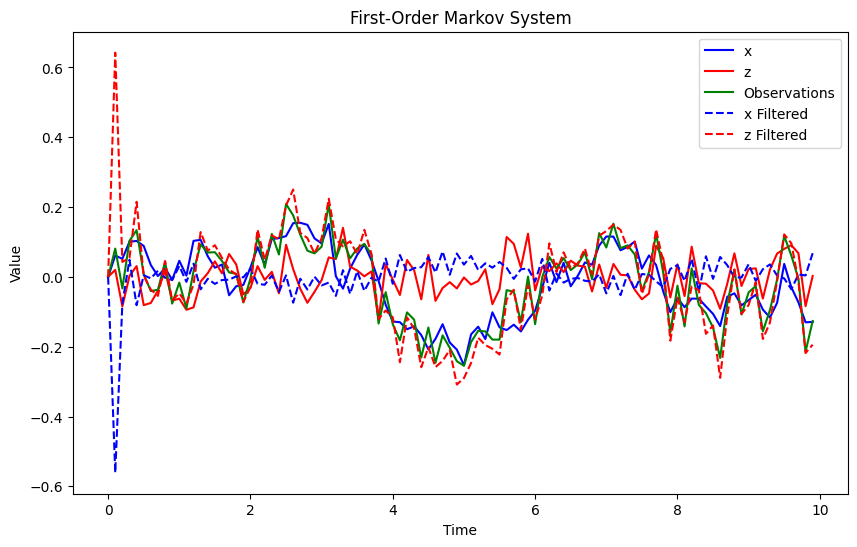

In [2]:
T = 10
dt = 0.1
t_space = np.arange(0, T, dt)

# Noise Parameters
var_x = 0.05
var_z = 0.05
var_y = 0.0


tau_x = 0.9
tau_z = 0.1


A = np.array([[(tau_x-1)/dt, 0], [0, (tau_z-1)/dt]])

initial_state = np.array([0.0, 0.0]).reshape((2, 1))
state_vec = dynamics(initial_state, t_space, A, dt, var_x, var_z)
x = state_vec[0, :]
z = state_vec[1, :]

H = np.array([1, 1]).reshape((1, 2))
obs = observations(H, state_vec, var_y)
covariance = np.diag([[var_x, 0], [0, var_z]])

state_hat = run_filter(initial_state.T, A, H, obs, covariance, obs_noise=var_y)

x_hat = state_hat[0, :]
z_hat = state_hat[1, :]
print('X error:', ((x-x_hat)**2).mean(), 'Z error: ', ((z-z_hat)**2).mean())
plt.figure(figsize=(10, 6))
plt.plot(t_space, x, 'b', label='x')
plt.plot(t_space, z, 'r', label='z')
plt.plot(t_space, obs, 'g', label='Observations')
plt.plot(t_space, x_hat, 'b', label = 'x Filtered ', linestyle='--')
plt.plot(t_space, z_hat, 'r', label = 'z Filtered ', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('First-Order Markov System')
plt.legend()
plt.show()


In [3]:
def create_sequences(data, window_size):
    sequences = []
    targets = []
    for i in range(len(data) - window_size):
        seq = data[i:i + window_size]
        target = data[i + window_size]
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

In [11]:
window_size = 10

# Creating sequences for training
x_sequences, x_targets = create_sequences(x, window_size)
z_sequences, z_targets = create_sequences(z, window_size)

# obs is the observed linear combination of x and z
obs_sequences, obs_targets = create_sequences(obs, window_size)
xz_targets = np.column_stack([x_targets, z_targets])

# Convert data to torch tensors
split_idx = int(0.7 * len(x_sequences))
xz_train = torch.tensor(xz_targets[:split_idx], dtype=torch.float64)
xz_test = torch.tensor(xz_targets[split_idx:], dtype=torch.float64)
obs_train = torch.tensor(obs_sequences[:split_idx], dtype=torch.float64)
obs_test = torch.tensor(obs_sequences[split_idx:], dtype=torch.float64)

# Standardize training data
obs_train = (obs_train - obs_train.mean()) / obs_train.std()
obs_test = (obs_test - obs_test.mean()) / obs_test.std()
xz_train = (xz_train - xz_train.mean()) / xz_train.std()
xz_test = (xz_test - xz_test.mean()) / xz_test.std()

# Reshape the observation sequences
obs_train = obs_train.view(-1, window_size)
obs_test = obs_test.view(-1, window_size)


In [10]:
# Model initialization
input_dim = window_size
hidden_layers = [100, 100, 100]
output_dim = 2

linear_model = AdaptingMLP(input_dim, hidden_layers, output_dim)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(linear_model.parameters(), lr=0.001, betas=(0.9, 0.99), amsgrad=True)  # Reduced learning rate

# Training loop
num_epochs = 100000
linear_model.train()

for epoch in range(num_epochs):
    prev_hidden_states = [None] * len(linear_model.adapting_layers)
    
    # Forward pass
    output, _ = linear_model(obs_train)
    
    # Calculate loss
    loss = criterion(output, xz_train)

    # Check for NaN loss
    if torch.isnan(loss):
        print("Loss is NaN. Stopping training.")
        break

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {loss.item():.5f}')

# Evaluation on test set

Epoch [10/100000], Training Loss: 0.41095
Epoch [20/100000], Training Loss: 0.38007
Epoch [30/100000], Training Loss: 0.36775
Epoch [40/100000], Training Loss: 0.35956
Epoch [50/100000], Training Loss: 0.35595
Epoch [60/100000], Training Loss: 0.35483
Epoch [70/100000], Training Loss: 0.35454
Epoch [80/100000], Training Loss: 0.35446
Epoch [90/100000], Training Loss: 0.35443
Epoch [100/100000], Training Loss: 0.35440
Epoch [110/100000], Training Loss: 0.35439
Epoch [120/100000], Training Loss: 0.35438
Epoch [130/100000], Training Loss: 0.35438
Epoch [140/100000], Training Loss: 0.35438
Epoch [150/100000], Training Loss: 0.35438
Epoch [160/100000], Training Loss: 0.35438
Epoch [170/100000], Training Loss: 0.35438
Epoch [180/100000], Training Loss: 0.35438
Epoch [190/100000], Training Loss: 0.35438
Epoch [200/100000], Training Loss: 0.35438
Epoch [210/100000], Training Loss: 0.35438
Epoch [220/100000], Training Loss: 0.35438
Epoch [230/100000], Training Loss: 0.35438
Epoch [240/100000], 

KeyboardInterrupt: 

In [12]:
linear_model.eval()

# Assuming sequential_rollout function
def sequential_rollout(model, obs_data, initial_hidden_states, output_length):
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        predictions = []
        prev_hidden_states = initial_hidden_states
        
        for i in range(obs_data.size(0)):
            output, prev_hidden_states = model(obs_data[i].unsqueeze(0), prev_hidden_states)
            predictions.append(output)

        # Concatenate predictions and limit to desired output length
        predicted_seq = torch.cat(predictions, dim=0)[:output_length]

    return predicted_seq

# When calling this function, ensure you specify the correct output length
initial_hidden_states = [None] * len(linear_model.adapting_layers)
predicted_output = sequential_rollout(linear_model, obs_test, prev_hidden_states, output_length=len(t_space)-window_size)
# # Run the sequential rollout on the entire observation dataset

# # Calculate the test loss and errors for both states
test_loss = criterion(predicted_output, torch.cat((xz_train, xz_test), dim=0))
error_x = torch.mean((predicted_output[:, 0] - torch.cat((xz_train, xz_test), dim=0)[:, 0]) ** 2).sqrt()
error_z = torch.mean((predicted_output[:, 1] - torch.cat((xz_train, xz_test), dim=0)[:, 1]) ** 2).sqrt()

print(f'Test Loss: {test_loss.item():.4f}, Error X: {error_x.item():.4f}, Error Z: {error_z.item():.4f}')

Test Loss: 29.1136, Error X: 7.5410, Error Z: 1.1665


In [15]:
initial_hidden_states

[None, None, None]

In [ ]:
test_loss

tensor(5.4017)

/var/folders/_c/7txhnt3n6jn42ys5t3wb9v8r0000gn/T/ipykernel_38742/2010966617.py:9: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-r" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(t_space[window_size:], predicted_output[:, 0], '-r', label = 'Adaptive X Estimate', linestyle='--')
/var/folders/_c/7txhnt3n6jn42ys5t3wb9v8r0000gn/T/ipykernel_38742/2010966617.py:10: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-b" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(t_space[window_size:], predicted_output[:,1], '-b', label = 'Adaptive Z Estimate', linestyle='--')


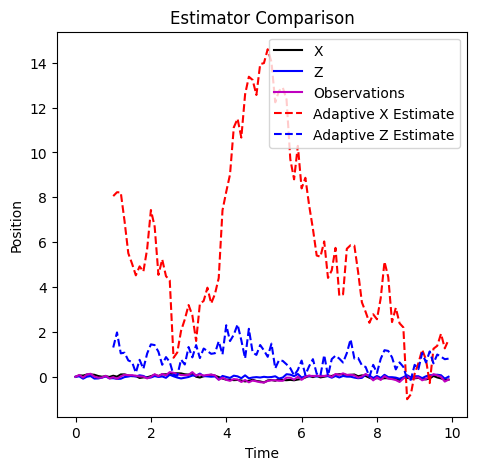

In [13]:
fig = plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
# Plot results
plt.plot(t_space, x, 'k', label='X')
plt.plot(t_space, z, 'b', label='Z')
plt.plot(t_space, obs, 'm', label='Observations')
#plt.plot(t_space, x_hat, 'g', label = 'Kalman Estimate ', linestyle='--')
plt.plot(t_space[window_size:], predicted_output[:, 0], '-r', label = 'Adaptive X Estimate', linestyle='--')
plt.plot(t_space[window_size:], predicted_output[:,1], '-b', label = 'Adaptive Z Estimate', linestyle='--')

#plt.plot(t_space[window_size:], ff_model_rollout.detach().numpy(), 'b', label = 'FF Network Estimate', linestyle='--')

#plt.ylim([-3, 3])
plt.xlabel('Time')
plt.ylabel('Position')
plt.title('Estimator Comparison')
plt.legend()


